In [1]:
import warnings
from pathlib import Path

import pandas as pd

from plot_utils import plot_map_per_config

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
def fmt(s):
    try:
        n = f"{float(s):.3f}"
    except:
        n = ""
    return n

#### Create configs for loading evalzoo results

In [3]:
results_dir = Path("../2.evalzoo/results/")
mertrics_filename = "metrics_level_1_ref"
figsave_path = Path("output/mAP_visualizations")

metrics_columns = {
    "sim_retrieval_average_precision_ref_i_mean_i": "mAP",
    "sim_retrieval_average_precision_ref_i_nlog10pvalue_mean_i": "-log(pvalue)",
    "sim_retrieval_average_precision_ref_i_nlog10qvalue_mean_i": "-log(qvalue)",
}

metrics = {
    # subset -> robustMAD -> feature select -> metrics
    "subset->preprocess\t\t": {
        "same_well_diff_pert": "0e4cd68f",
        "same_pert_diff_well": "ceb5f02a",
        "same_well_same_pert": "34fbd8a4",
    },
    # subset -> correct -> robustMAD -> feature select -> metrics
    "subset->well_correct->preprocess\t": {
        "same_well_diff_pert": "82ad004e",
        "same_pert_diff_well": "f5c36cb4",
        "same_well_same_pert": "d66f1bce",
    },
    # correct -> robustMAD -> feature select -> subset -> metrics
    "well_correct->subset->preprocess\t": {
        "same_well_diff_pert": "3ec971b2",
        "same_pert_diff_well": "72f94e10",
        "same_well_same_pert": "138739c0",
    },
    # subset -> robustMAD -> feature select -> cell count correct -> metrics
    "subset->preprocess->cc_correct\t": {
        "same_well_diff_pert": "3701ed2c",
        "same_pert_diff_well": "440d5bda",
        "same_well_same_pert": "a69994b0",
    },
    # subset -> rcell count correct -> robustMAD -> feature select -> metrics
    "subset->cc_correct->preprocess\t": {
        "same_well_diff_pert": "d2311b58",
        "same_pert_diff_well": "5f53102a",
        "same_well_same_pert": "e2bf955d",
    },
}

groupby_columns = {
    "same_well_diff_pert": ["Metadata_Well"],
    "same_pert_diff_well": ["Metadata_JCP2022"],
    "same_well_same_pert": ["Metadata_Well", "Metadata_JCP2022"],
}

#### Load evalzoo metrics

In [4]:
metrics_dfs = []

for subset, configs in metrics.items():
    for config, config_dir in configs.items():
        metric_cols = list(metrics_columns.keys())
        metrics_path = results_dir / config_dir / f"{mertrics_filename}.parquet"
        metrics_df = pd.read_parquet(metrics_path, columns=metric_cols + groupby_columns[config])
        metrics_df = metrics_df.groupby(groupby_columns[config])[metric_cols].mean().reset_index()
        # metrics_df.drop(groupby_columns[config], axis=1, inplace=True)
        metrics_df.rename(columns=metrics_columns, inplace=True)
        metrics_df["config"] = config
        metrics_df["subset"] = subset
        metrics_df["p<0.05"] = metrics_df["-log(pvalue)"] > 1.3
        metrics_dfs.append(metrics_df)

In [5]:
metrics_df = pd.concat(metrics_dfs, axis=0)
metrics_df.shape

(20290, 8)

#### Plot mAP scatterplots and densities

same_well_diff_pert subset->preprocess	 mmAP: 0.0634 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.0594 p<0.05: 0.0353 (13/368)
same_well_diff_pert well_correct->subset->preprocess	 mmAP: 0.0978 p<0.05: 0.166 (61/368)
same_well_diff_pert subset->preprocess->cc_correct	 mmAP: 0.0564 p<0.05: 0.0489 (18/368)
same_well_diff_pert subset->cc_correct->preprocess	 mmAP: 0.053 p<0.05: 0.0 (0/368)


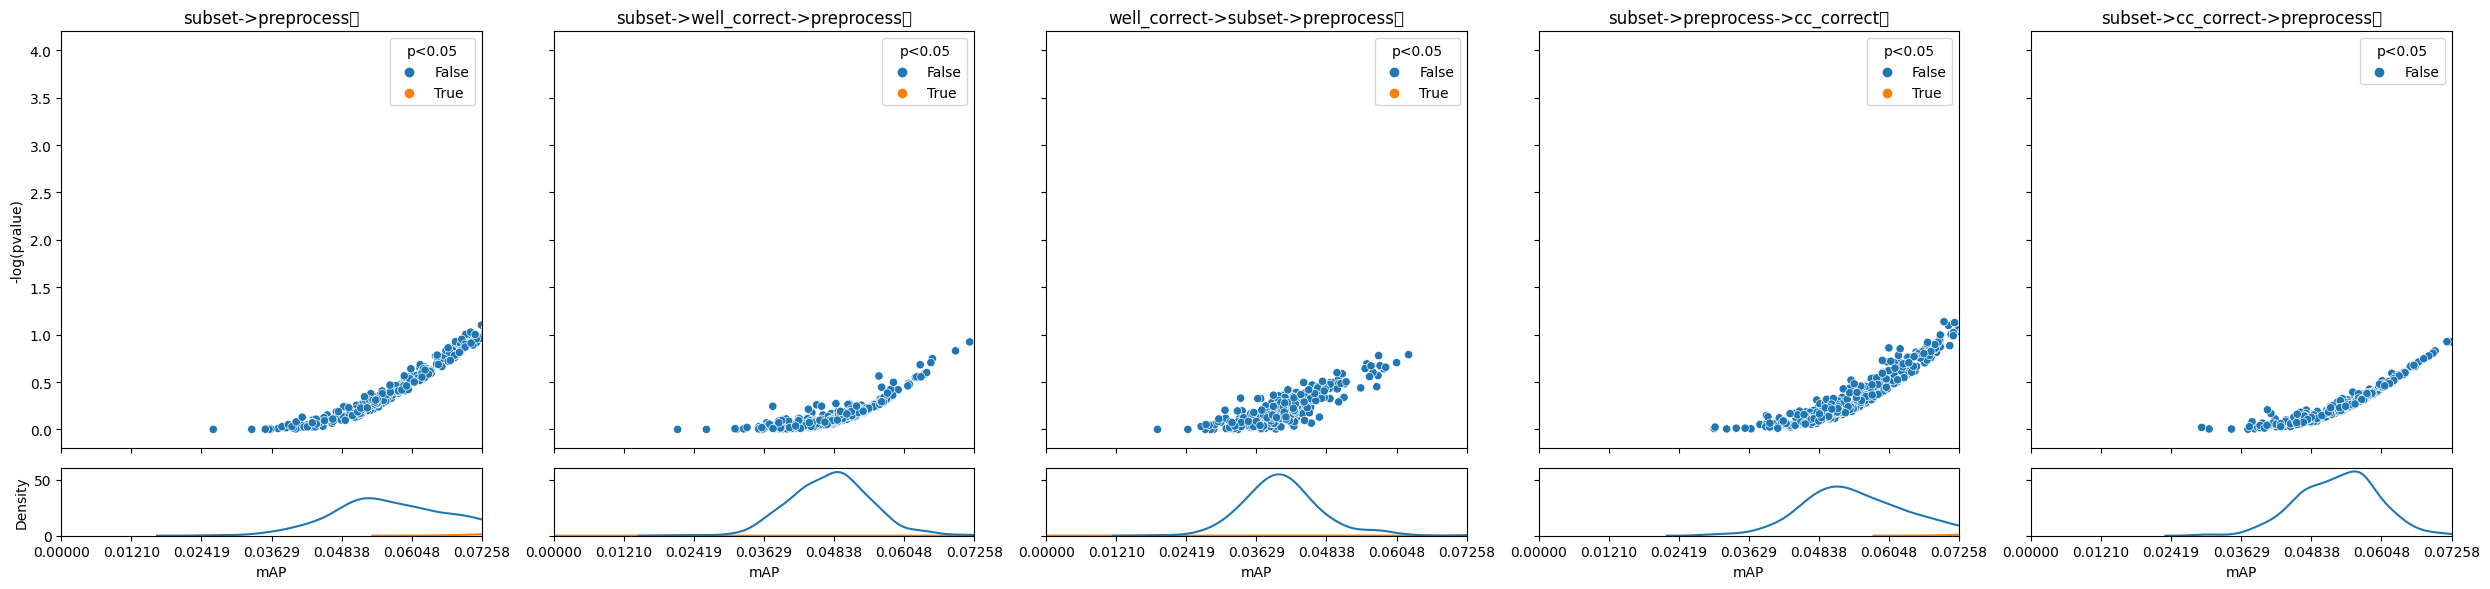

same_pert_diff_well subset->preprocess	 mmAP: 0.00961 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0135 p<0.05: 0.0 (0/37)
same_pert_diff_well well_correct->subset->preprocess	 mmAP: 0.0102 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->preprocess->cc_correct	 mmAP: 0.013 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->cc_correct->preprocess	 mmAP: 0.0129 p<0.05: 0.0 (0/37)


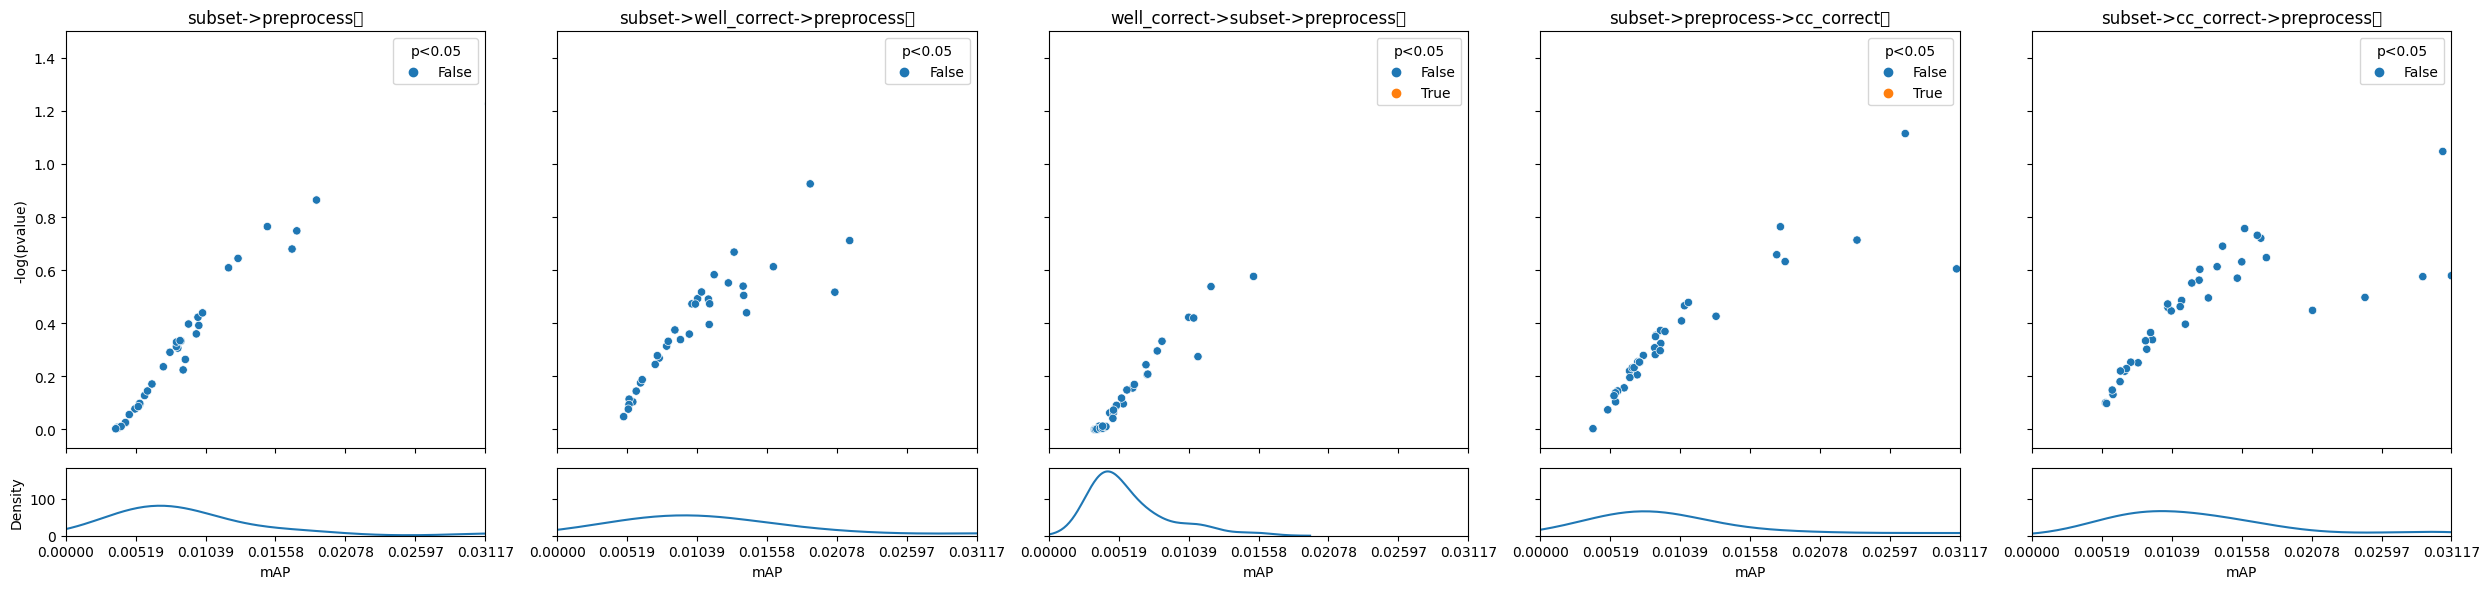

same_well_same_pert subset->preprocess	 mmAP: 0.197 p<0.05: 0.902 (3295/3653)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.165 p<0.05: 0.775 (2831/3653)
same_well_same_pert well_correct->subset->preprocess	 mmAP: 0.243 p<0.05: 0.684 (2499/3653)
same_well_same_pert subset->preprocess->cc_correct	 mmAP: 0.0887 p<0.05: 0.499 (1822/3653)
same_well_same_pert subset->cc_correct->preprocess	 mmAP: 0.0535 p<0.05: 0.0 (0/3653)


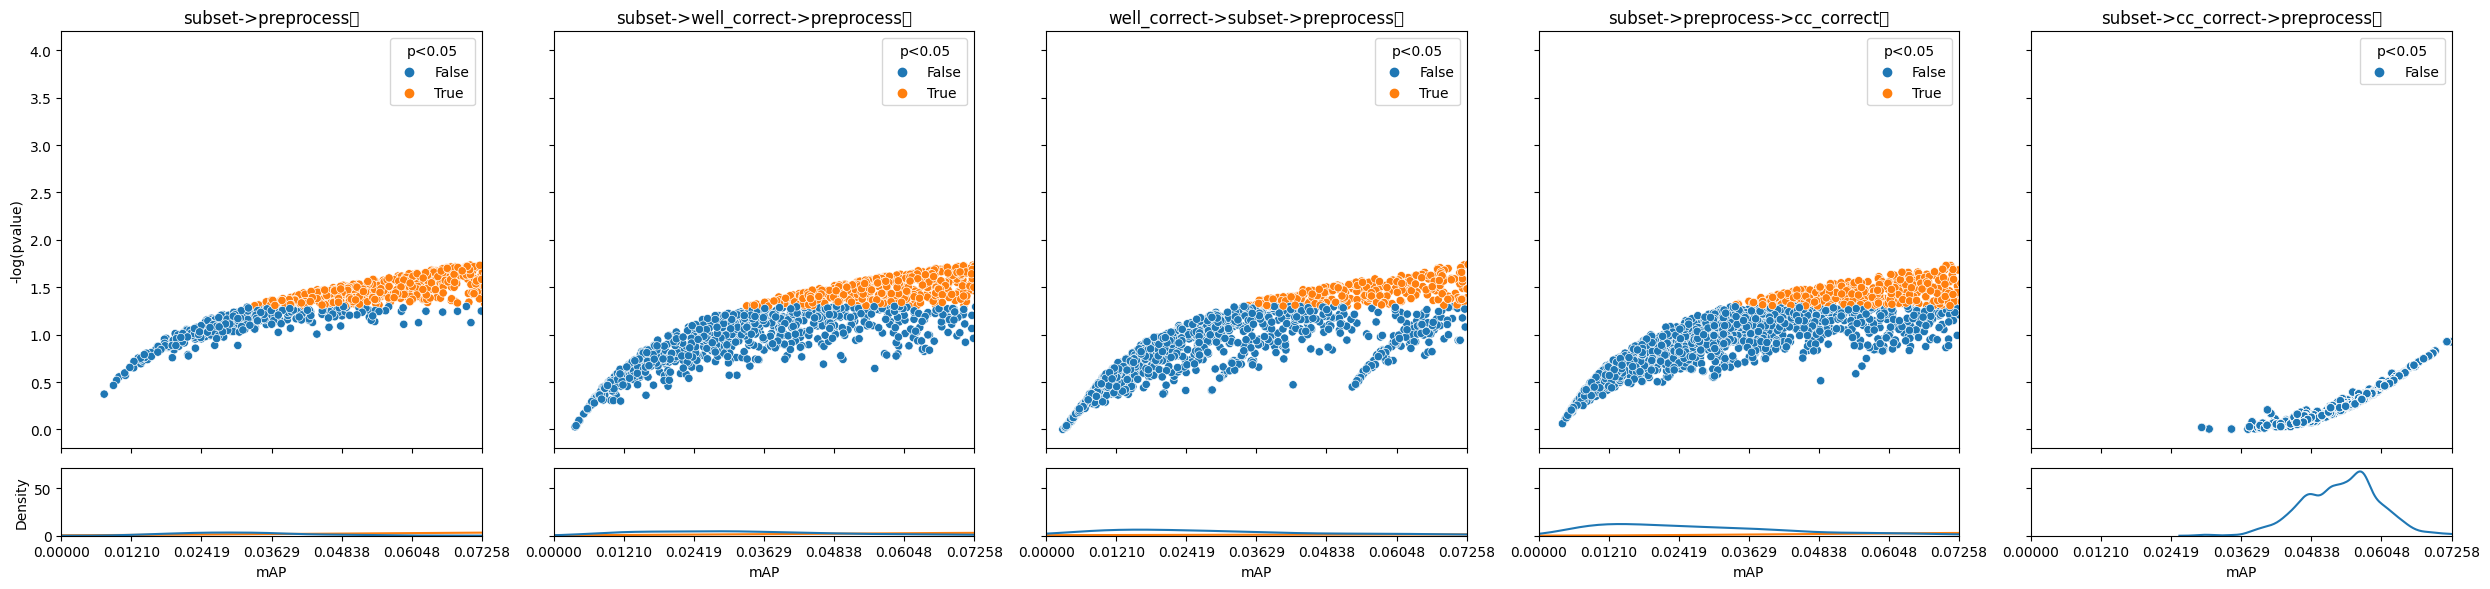

In [6]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, figsave_path=figsave_path)

### Explore calculated metrics on low/high cell count variability ORFs

In [7]:
ann_df_trt_low_cvar = pd.read_parquet("../1.load/output/subset_profiles_low_cvar_metadata.parquet")
ann_df_trt_low_cvar

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Plate_Map_Name,Metadata_Count_Cells
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt,source_4,BR00126538,B21,OAB37.38.39.40.A,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,2529.0,trt,source_4,BR00126538,I15,OAB37.38.39.40.A,1245
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,2280.0,trt,source_4,BR00126538,L17,OAB37.38.39.40.A,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,2238.0,trt,source_4,BR00126538,L20,OAB37.38.39.40.A,1072
6,JCP2022_900392,ccsbBroad304_00423,ORF005089.1_TRC304.1,pLX_304,NM_001350.5,DAXX,1616,9606,death domain associated protein,100.0,2220.0,trt,source_4,BR00126538,L11,OAB37.38.39.40.A,1011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19122,JCP2022_915014,ccsbBroad304_16053,ORF001543.1_TRC304.1,pLX_304,NM_033364.4,MAATS1,89876,9606,MYCBP associated and testis expressed 1,99.8,2301.0,trt,source_4,BR00123791,D06,OAB41.OAC17.OAB78.79.A,1134
19124,JCP2022_915024,ccsbBroad304_16064,ORF006054.1_TRC304.1,pLX_304,NM_001077594.1,EXOC3L4,91828,9606,exocyst complex component 3 like 4,99.7,2166.0,trt,source_4,BR00123791,D14,OAB41.OAC17.OAB78.79.A,996
19125,JCP2022_915028,ccsbBroad304_16068,ORF008706.1_TRC304.1,pLX_304,NM_001286829.2,NAPRT,93100,9606,nicotinate phosphoribosyltransferase,86.0,1398.0,trt,source_4,BR00123791,C15,OAB41.OAC17.OAB78.79.A,1058
19126,JCP2022_915030,ccsbBroad304_16070,ORF000807.1_TRC304.1,pLX_304,NM_144577.4,CCDC114,93233,9606,coiled-coil domain containing 114,69.1,1389.0,trt,source_4,BR00123791,M21,OAB41.OAC17.OAB78.79.A,1054


In [8]:
print("ORFs in subset profiles:", len(metrics_df["Metadata_JCP2022"].unique()))
print("ORFs in low cell count variability profiles:", len(ann_df_trt_low_cvar["Metadata_JCP2022"].unique()))

print("Overlap: ", len(set(metrics_df["Metadata_JCP2022"].unique()) & set(ann_df_trt_low_cvar["Metadata_JCP2022"].unique())))

ORFs in subset profiles: 3617
ORFs in low cell count variability profiles: 2588
Overlap:  2588


In [9]:
metrics_low_ccv_df = metrics_df[metrics_df["Metadata_JCP2022"].isin(ann_df_trt_low_cvar["Metadata_JCP2022"].unique())]
metrics_low_ccv_df

,Metadata_Well,mAP,-log(pvalue),-log(qvalue),config,subset,p<0.05,Metadata_JCP2022
2,NaN,0.005463,0.094635,0.002441,same_pert_diff_well,subset->preprocess\t,False,JCP2022_900475
8,NaN,0.003867,0.008563,0.002441,same_pert_diff_well,subset->preprocess\t,False,JCP2022_905771
10,NaN,0.008729,0.224090,0.002441,same_pert_diff_well,subset->preprocess\t,False,JCP2022_906612
12,NaN,0.014985,0.764146,0.002441,same_pert_diff_well,subset->preprocess\t,False,JCP2022_908657
13,NaN,0.005147,0.077058,0.002441,same_pert_diff_well,subset->preprocess\t,False,JCP2022_909454
...,...,...,...,...,...,...,...,...
3638,P15,0.045963,0.160263,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_904560
3639,P15,0.045963,0.160263,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_905030
3643,P16,0.057097,0.316290,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_901063
3648,P16,0.057097,0.316290,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_908199


In [10]:
metrics_high_ccv_df = metrics_df[~metrics_df["Metadata_JCP2022"].isin(ann_df_trt_low_cvar["Metadata_JCP2022"].unique())]
metrics_high_ccv_df

,Metadata_Well,mAP,-log(pvalue),-log(qvalue),config,subset,p<0.05,Metadata_JCP2022
0,A01,0.120856,2.245085,0.814117,same_well_diff_pert,subset->preprocess\t,True,NaN
1,A02,0.109512,2.089503,0.796366,same_well_diff_pert,subset->preprocess\t,True,NaN
2,A03,0.088952,1.527725,0.566763,same_well_diff_pert,subset->preprocess\t,True,NaN
3,A04,0.094387,1.684785,0.620940,same_well_diff_pert,subset->preprocess\t,True,NaN
4,A05,0.080698,1.210576,0.461507,same_well_diff_pert,subset->preprocess\t,False,NaN
...,...,...,...,...,...,...,...,...
3646,P16,0.057097,0.316290,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_903499
3647,P16,0.057097,0.316290,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_908011
3650,P16,0.057097,0.316290,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_911429
3651,P16,0.057097,0.316290,0.029988,same_well_same_pert,subset->cc_correct->preprocess\t,False,JCP2022_914539


#### Low CCV

same_pert_diff_well subset->preprocess	 mmAP: 0.0119 p<0.05: 0.0 (0/12)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0136 p<0.05: 0.0 (0/12)
same_pert_diff_well well_correct->subset->preprocess	 mmAP: 0.00543 p<0.05: 0.0 (0/12)
same_pert_diff_well subset->preprocess->cc_correct	 mmAP: 0.0193 p<0.05: 0.0833 (1/12)
same_pert_diff_well subset->cc_correct->preprocess	 mmAP: 0.0113 p<0.05: 0.0 (0/12)


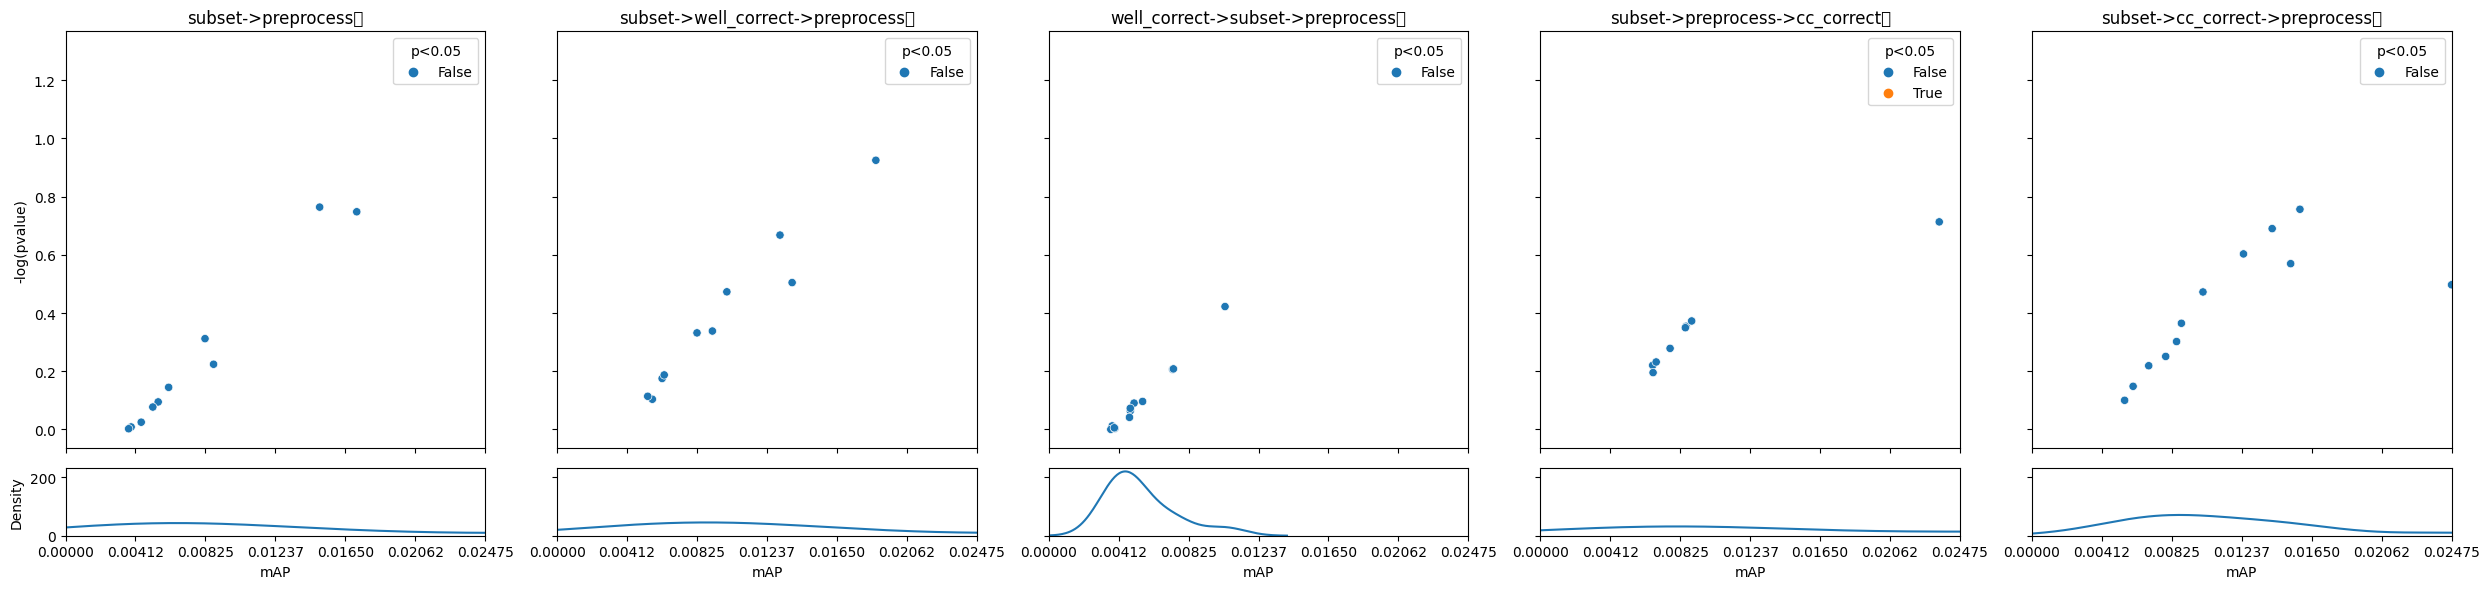

same_well_same_pert subset->preprocess	 mmAP: 0.231 p<0.05: 0.969 (2519/2600)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.177 p<0.05: 0.816 (2121/2600)
same_well_same_pert well_correct->subset->preprocess	 mmAP: 0.242 p<0.05: 0.7 (1821/2600)
same_well_same_pert subset->preprocess->cc_correct	 mmAP: 0.101 p<0.05: 0.585 (1521/2600)
same_well_same_pert subset->cc_correct->preprocess	 mmAP: 0.0531 p<0.05: 0.0 (0/2600)


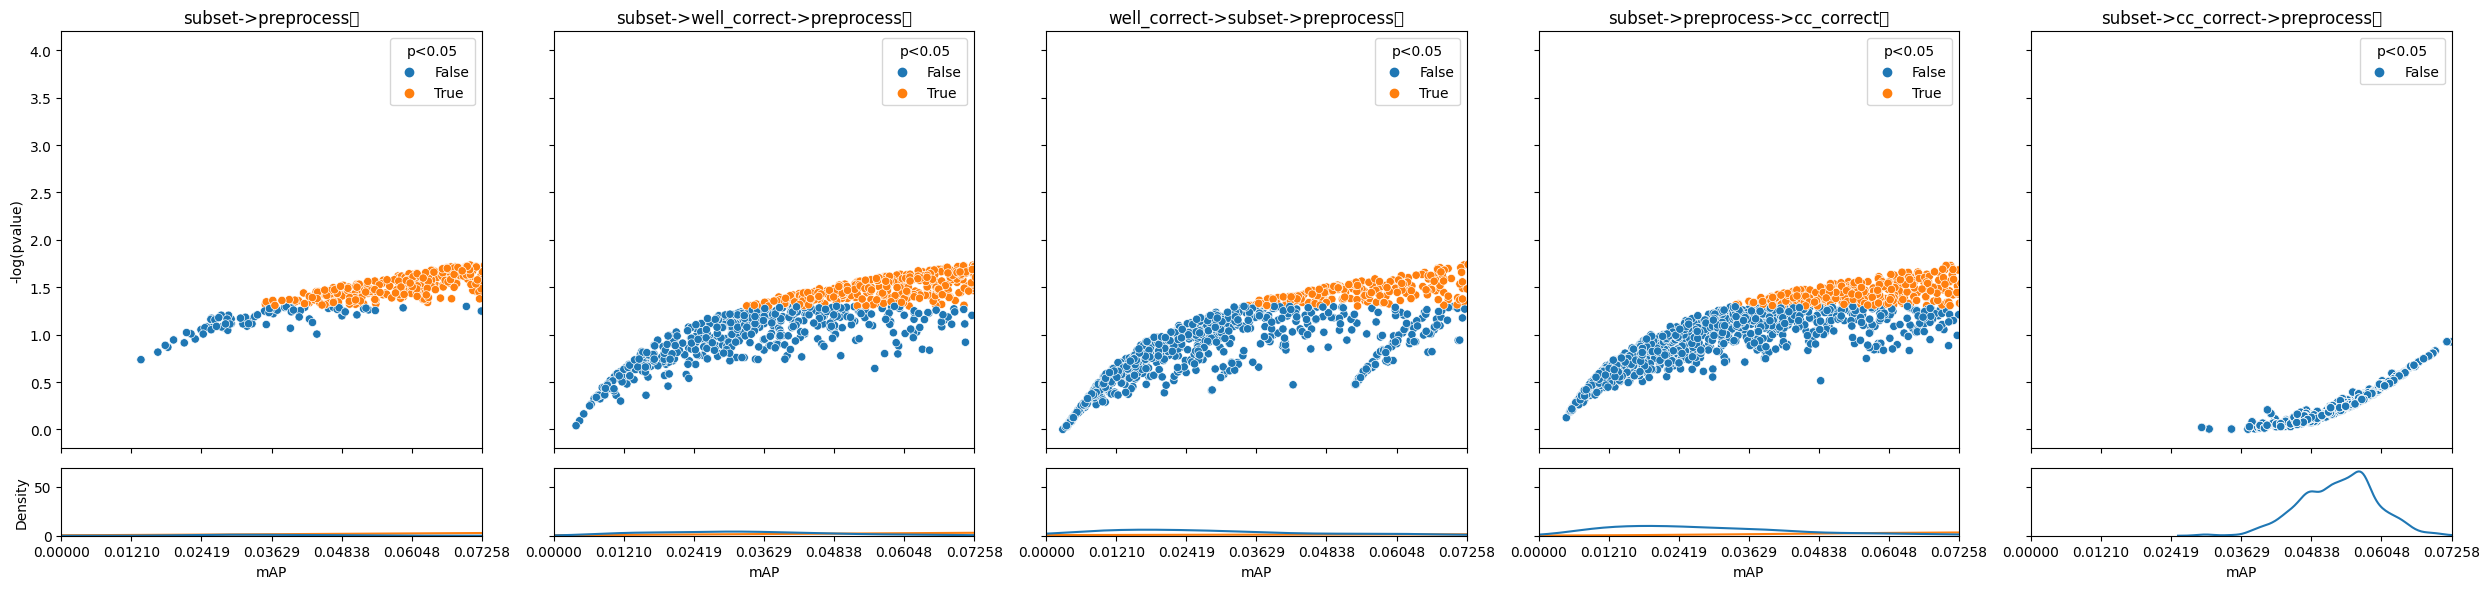

In [11]:
for config in metrics_low_ccv_df.config.unique():
    config_df = metrics_low_ccv_df[metrics_low_ccv_df.config==config]
    plot_map_per_config(config_df, config, figsave_path=figsave_path / "low_ccv")

#### High CCV

same_well_diff_pert subset->preprocess	 mmAP: 0.0634 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.0594 p<0.05: 0.0353 (13/368)
same_well_diff_pert well_correct->subset->preprocess	 mmAP: 0.0978 p<0.05: 0.166 (61/368)
same_well_diff_pert subset->preprocess->cc_correct	 mmAP: 0.0564 p<0.05: 0.0489 (18/368)
same_well_diff_pert subset->cc_correct->preprocess	 mmAP: 0.053 p<0.05: 0.0 (0/368)


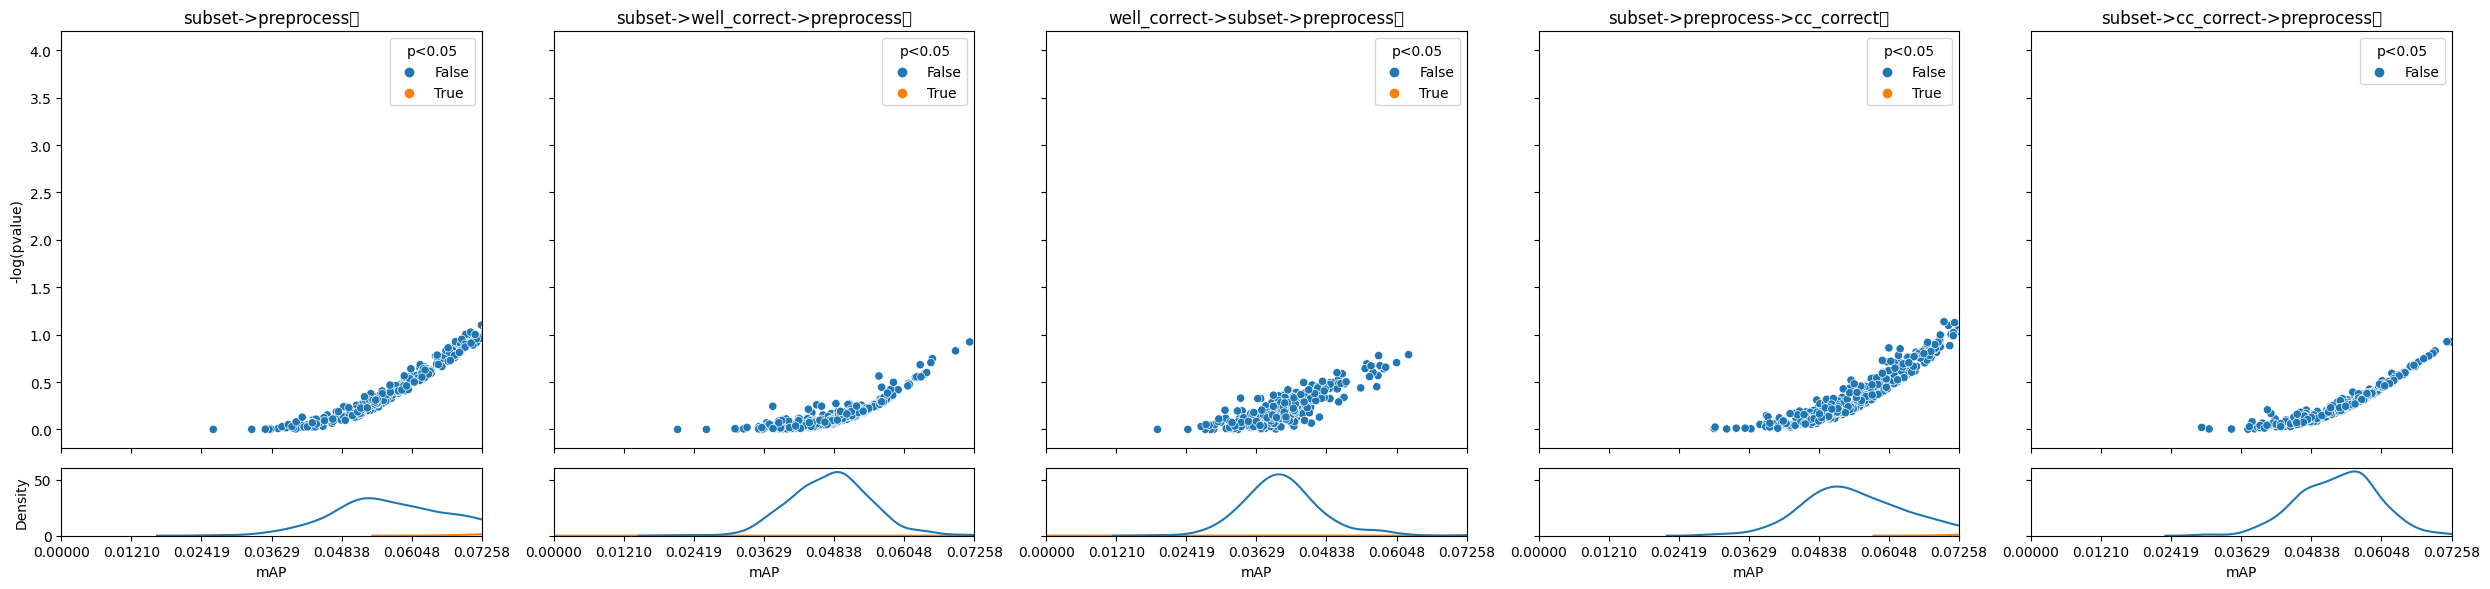

same_pert_diff_well subset->preprocess	 mmAP: 0.0085 p<0.05: 0.0 (0/25)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0135 p<0.05: 0.0 (0/25)
same_pert_diff_well well_correct->subset->preprocess	 mmAP: 0.0126 p<0.05: 0.04 (1/25)
same_pert_diff_well subset->preprocess->cc_correct	 mmAP: 0.0099 p<0.05: 0.0 (0/25)
same_pert_diff_well subset->cc_correct->preprocess	 mmAP: 0.0136 p<0.05: 0.0 (0/25)


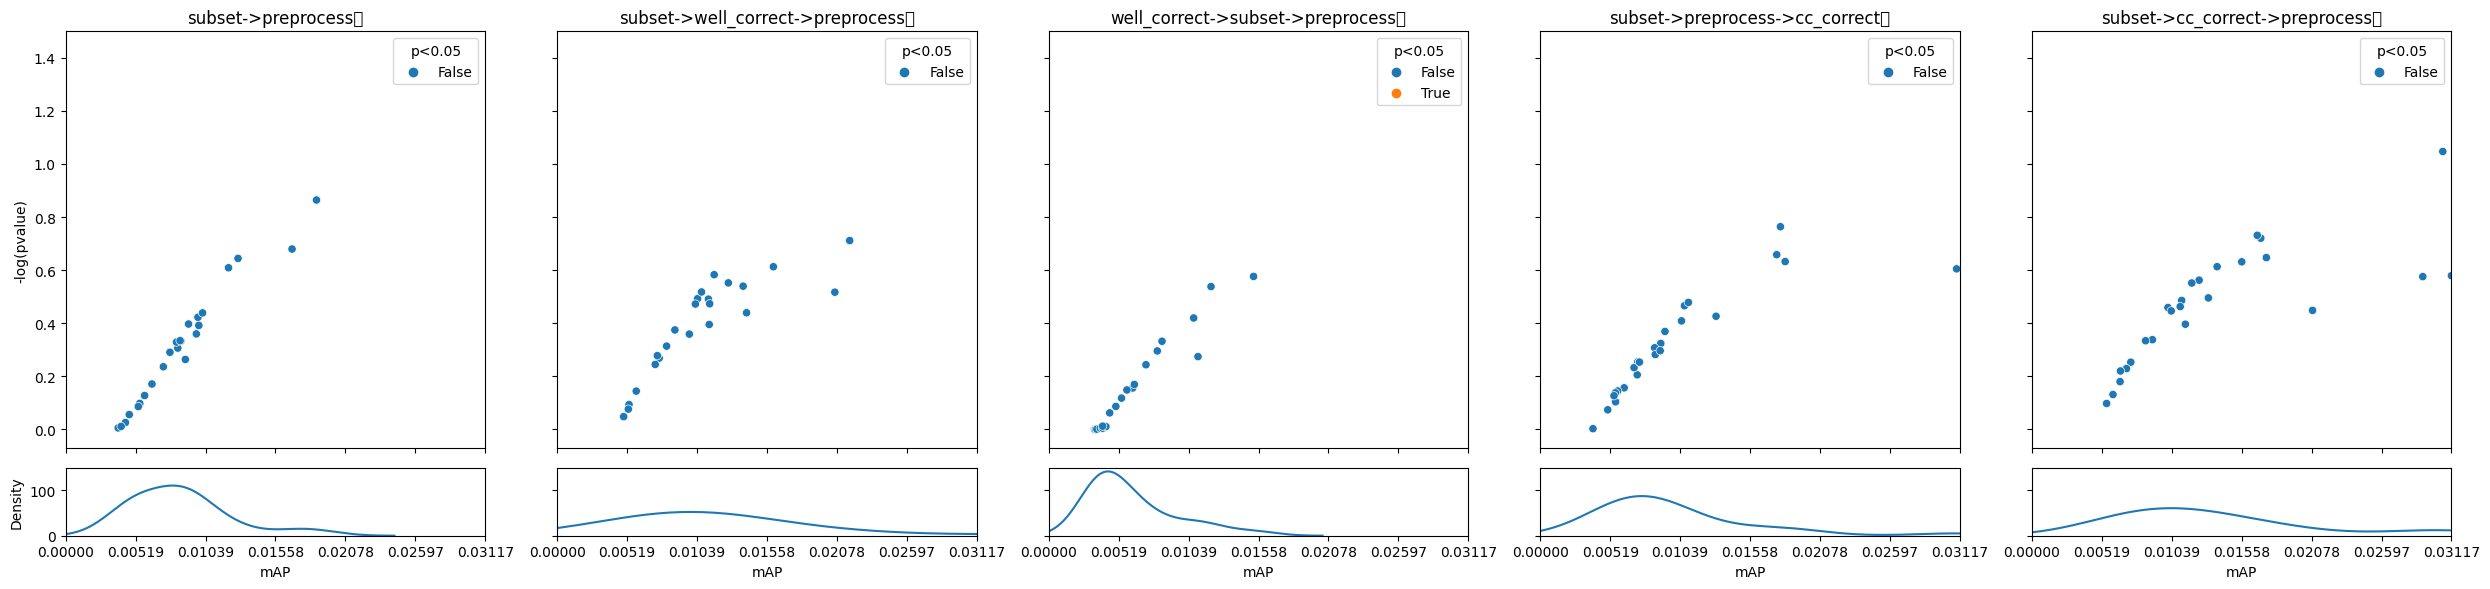

same_well_same_pert subset->preprocess	 mmAP: 0.113 p<0.05: 0.737 (776/1053)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.134 p<0.05: 0.674 (710/1053)
same_well_same_pert well_correct->subset->preprocess	 mmAP: 0.245 p<0.05: 0.644 (678/1053)
same_well_same_pert subset->preprocess->cc_correct	 mmAP: 0.0589 p<0.05: 0.286 (301/1053)
same_well_same_pert subset->cc_correct->preprocess	 mmAP: 0.0546 p<0.05: 0.0 (0/1053)


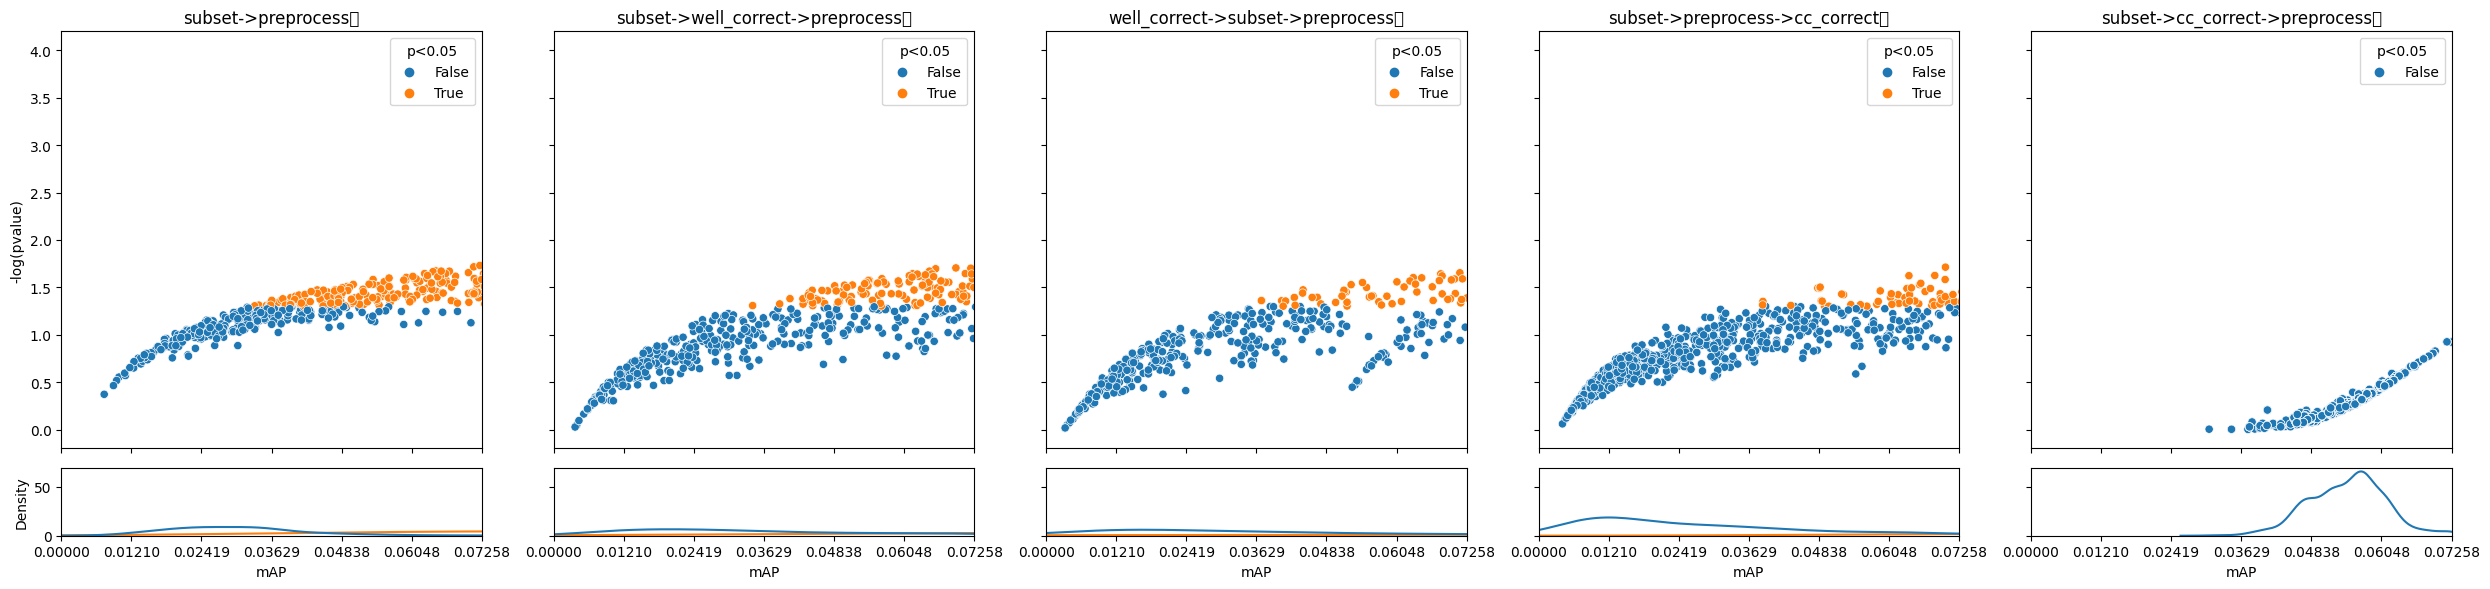

In [12]:
for config in metrics_high_ccv_df.config.unique():
    config_df = metrics_high_ccv_df[metrics_high_ccv_df.config==config]
    plot_map_per_config(config_df, config, figsave_path=figsave_path / "high_ccv")

### Explore relationship between cell count variability and mAP

In [13]:
cell_count_cvar = pd.read_csv("../1.load/output/cell_count_per_orf.csv")
cell_count_cvar

,Metadata_JCP2022,Metadata_Cell_Count_CoV
0,JCP2022_900006,0.052080
1,JCP2022_900008,0.133191
2,JCP2022_900012,0.052447
3,JCP2022_900014,0.084927
4,JCP2022_900015,0.087774
...,...,...
3611,JCP2022_915120,0.098188
3612,JCP2022_915123,0.076138
3613,JCP2022_915125,0.110349
3614,JCP2022_915126,0.052932


#### Merge metrics and cell count CoV on JCP id

The only difference is metrics have `NaNs` due to `same_well_diff_pert`

In [14]:
print("Diff:", set(metrics_df.Metadata_JCP2022.unique()).symmetric_difference(set(cell_count_cvar.Metadata_JCP2022.unique())))

metrics_df = metrics_df.merge(cell_count_cvar, on="Metadata_JCP2022", how="left")
metrics_df.head(3)

Diff: {nan}


,Metadata_Well,mAP,-log(pvalue),-log(qvalue),config,subset,p<0.05,Metadata_JCP2022,Metadata_Cell_Count_CoV
0,A01,0.120856,2.245085,0.814117,same_well_diff_pert,subset->preprocess\t,True,NaN,NaN
1,A02,0.109512,2.089503,0.796366,same_well_diff_pert,subset->preprocess\t,True,NaN,NaN
2,A03,0.088952,1.527725,0.566763,same_well_diff_pert,subset->preprocess\t,True,NaN,NaN


same_well_diff_pert subset->preprocess	 mmAP: 0.0634 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.0594 p<0.05: 0.0353 (13/368)
same_well_diff_pert well_correct->subset->preprocess	 mmAP: 0.0978 p<0.05: 0.166 (61/368)
same_well_diff_pert subset->preprocess->cc_correct	 mmAP: 0.0564 p<0.05: 0.0489 (18/368)
same_well_diff_pert subset->cc_correct->preprocess	 mmAP: 0.053 p<0.05: 0.0 (0/368)


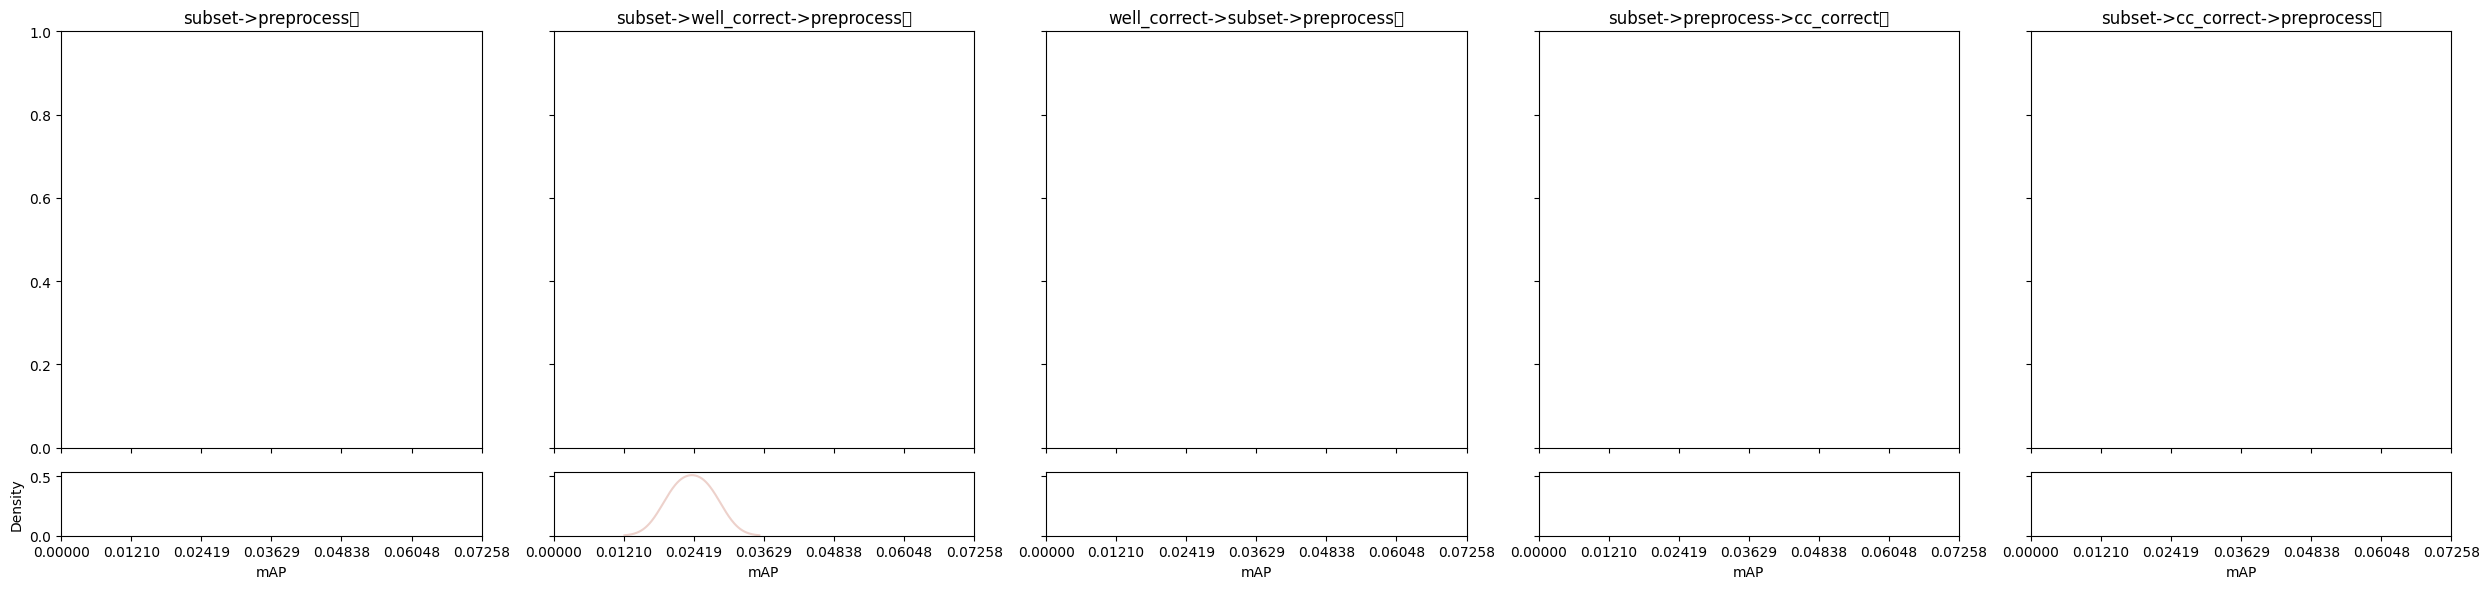

same_pert_diff_well subset->preprocess	 mmAP: 0.00961 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0135 p<0.05: 0.0 (0/37)
same_pert_diff_well well_correct->subset->preprocess	 mmAP: 0.0102 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->preprocess->cc_correct	 mmAP: 0.013 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->cc_correct->preprocess	 mmAP: 0.0129 p<0.05: 0.0 (0/37)


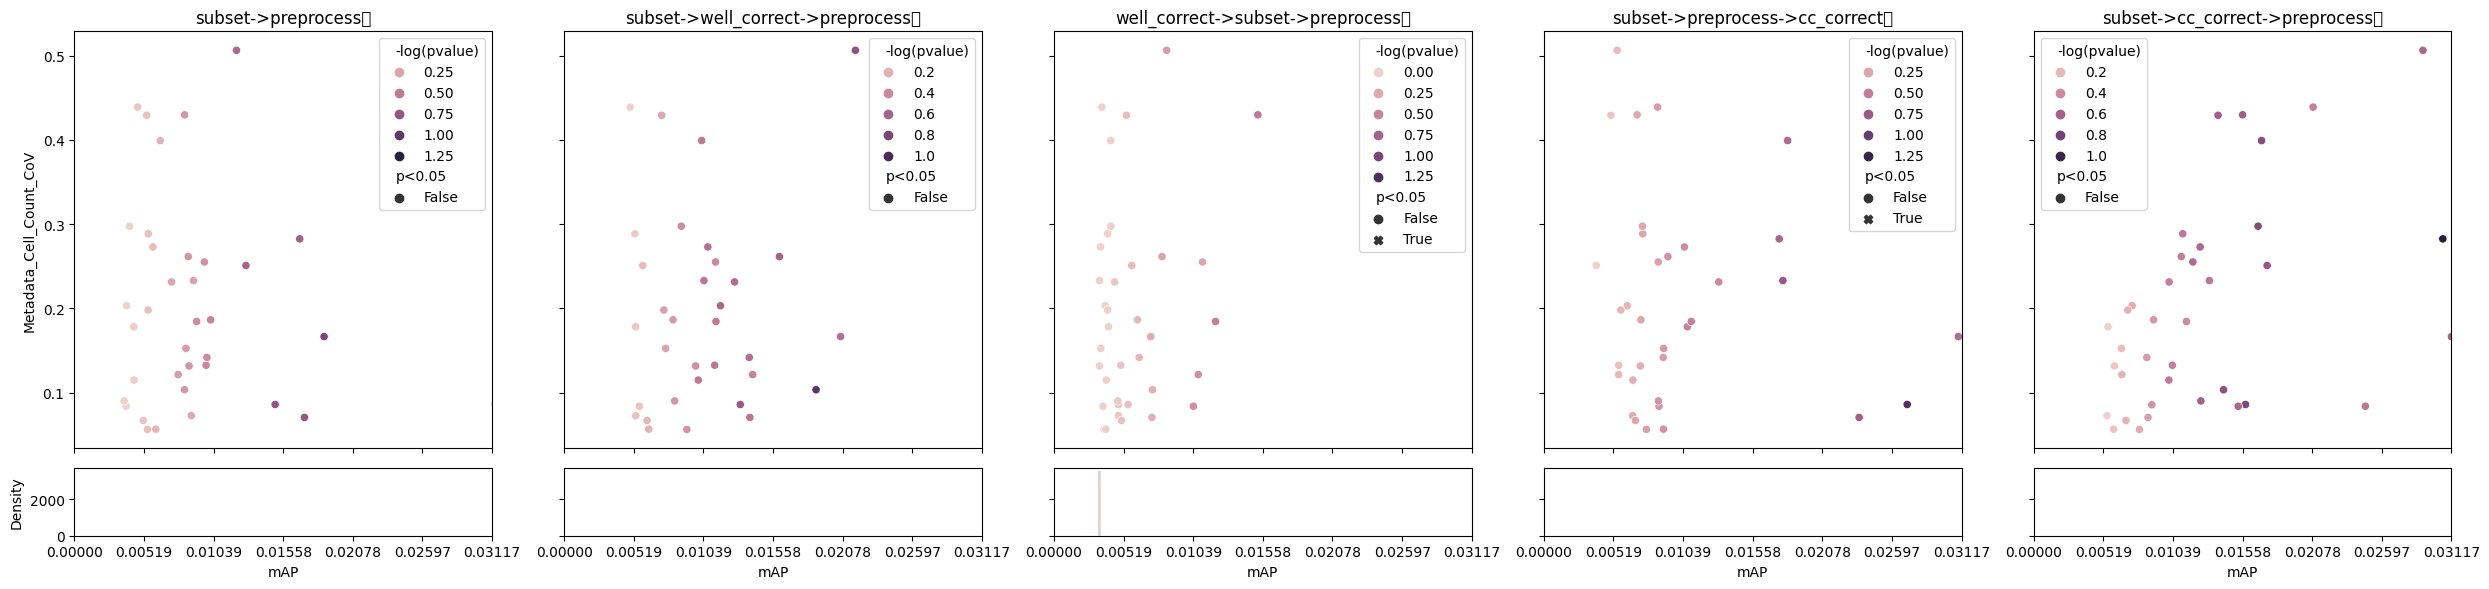

same_well_same_pert subset->preprocess	 mmAP: 0.197 p<0.05: 0.902 (3295/3653)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.165 p<0.05: 0.775 (2831/3653)
same_well_same_pert well_correct->subset->preprocess	 mmAP: 0.243 p<0.05: 0.684 (2499/3653)
same_well_same_pert subset->preprocess->cc_correct	 mmAP: 0.0887 p<0.05: 0.499 (1822/3653)
same_well_same_pert subset->cc_correct->preprocess	 mmAP: 0.0535 p<0.05: 0.0 (0/3653)


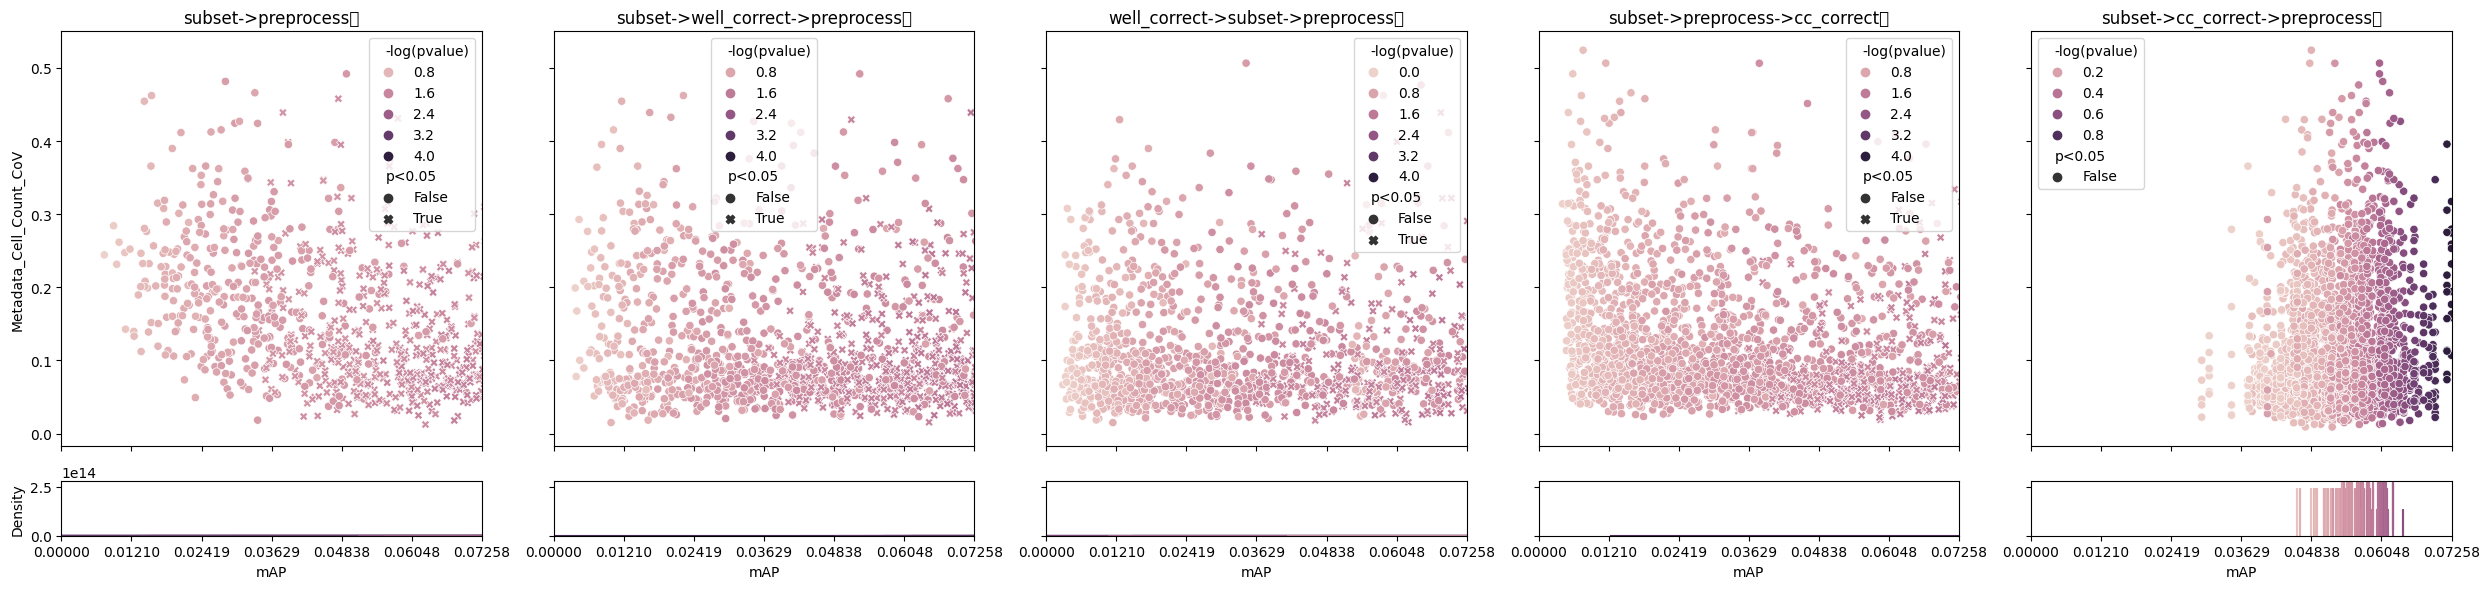

In [15]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, y_col="Metadata_Cell_Count_CoV",
                        hue_col="-log(pvalue)", style_col="p<0.05",
                         figsave_path=figsave_path / "map_vs_ccv")

same_well_diff_pert subset->preprocess	 mmAP: 0.0634 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.0594 p<0.05: 0.0353 (13/368)
same_well_diff_pert well_correct->subset->preprocess	 mmAP: 0.0978 p<0.05: 0.166 (61/368)
same_well_diff_pert subset->preprocess->cc_correct	 mmAP: 0.0564 p<0.05: 0.0489 (18/368)
same_well_diff_pert subset->cc_correct->preprocess	 mmAP: 0.053 p<0.05: 0.0 (0/368)


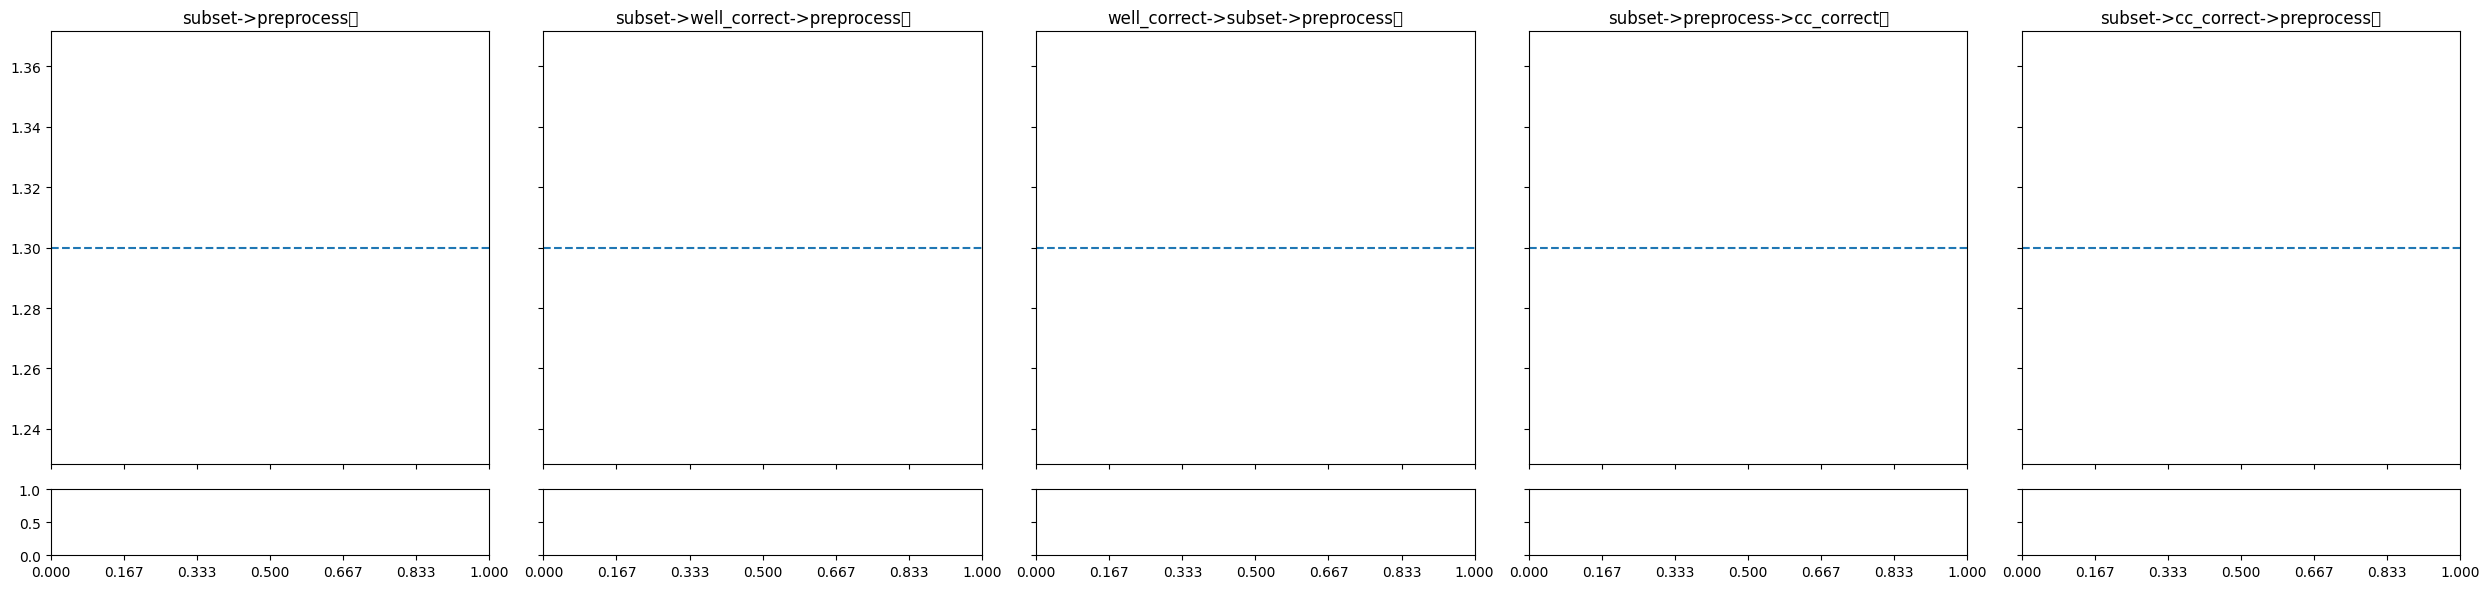

same_pert_diff_well subset->preprocess	 mmAP: 0.00961 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0135 p<0.05: 0.0 (0/37)
same_pert_diff_well well_correct->subset->preprocess	 mmAP: 0.0102 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->preprocess->cc_correct	 mmAP: 0.013 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->cc_correct->preprocess	 mmAP: 0.0129 p<0.05: 0.0 (0/37)


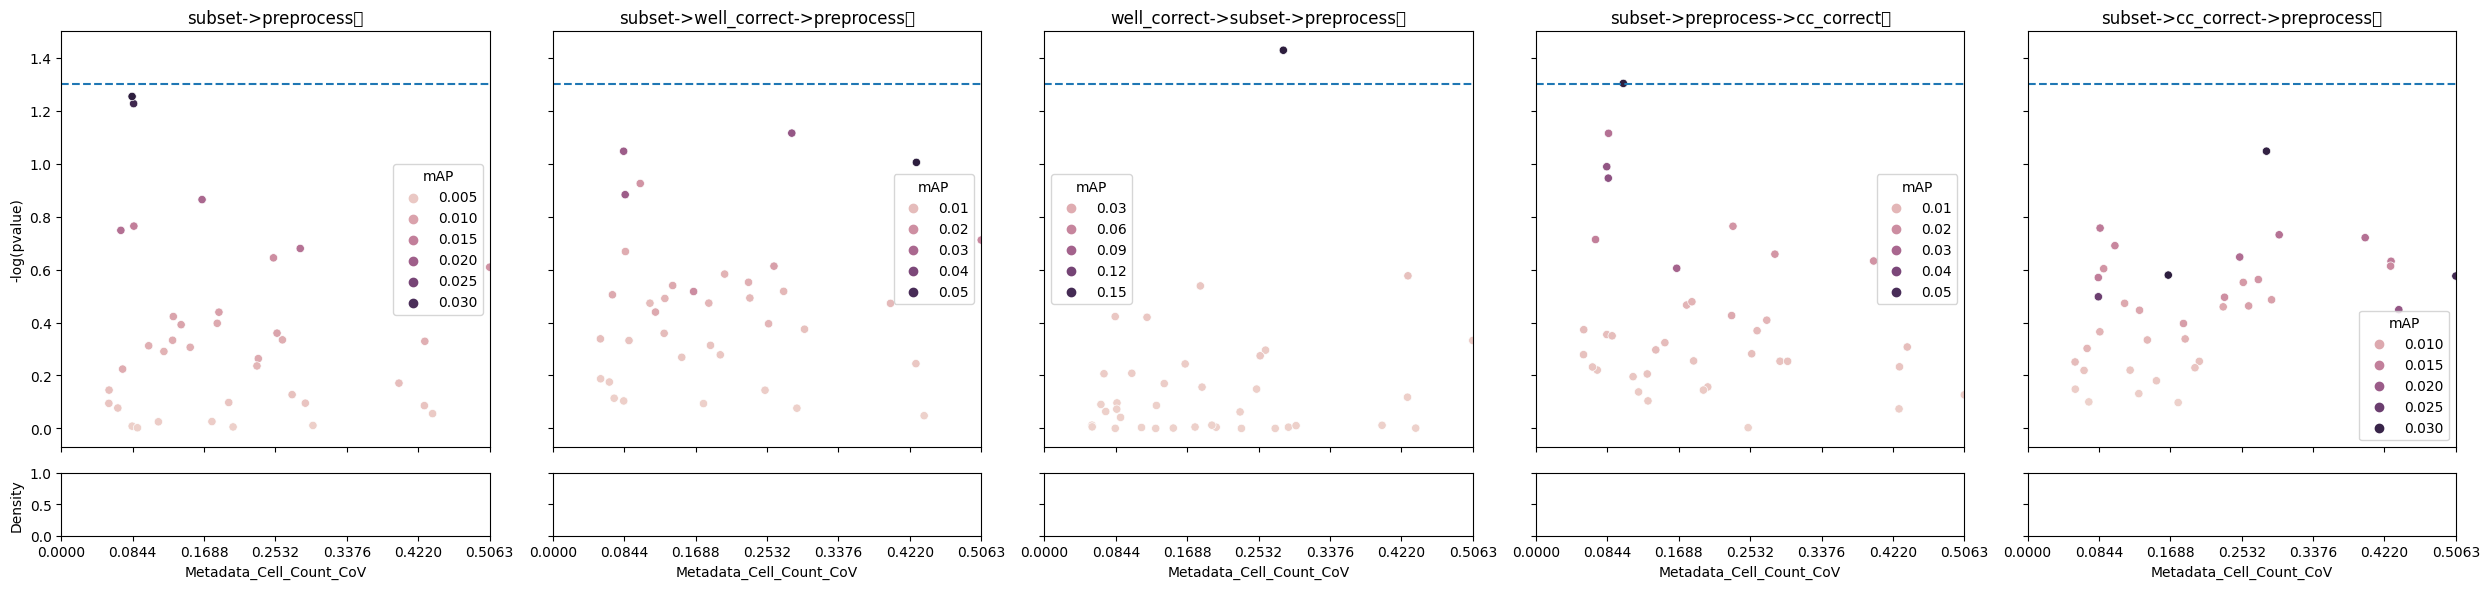

same_well_same_pert subset->preprocess	 mmAP: 0.197 p<0.05: 0.902 (3295/3653)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.165 p<0.05: 0.775 (2831/3653)
same_well_same_pert well_correct->subset->preprocess	 mmAP: 0.243 p<0.05: 0.684 (2499/3653)
same_well_same_pert subset->preprocess->cc_correct	 mmAP: 0.0887 p<0.05: 0.499 (1822/3653)
same_well_same_pert subset->cc_correct->preprocess	 mmAP: 0.0535 p<0.05: 0.0 (0/3653)


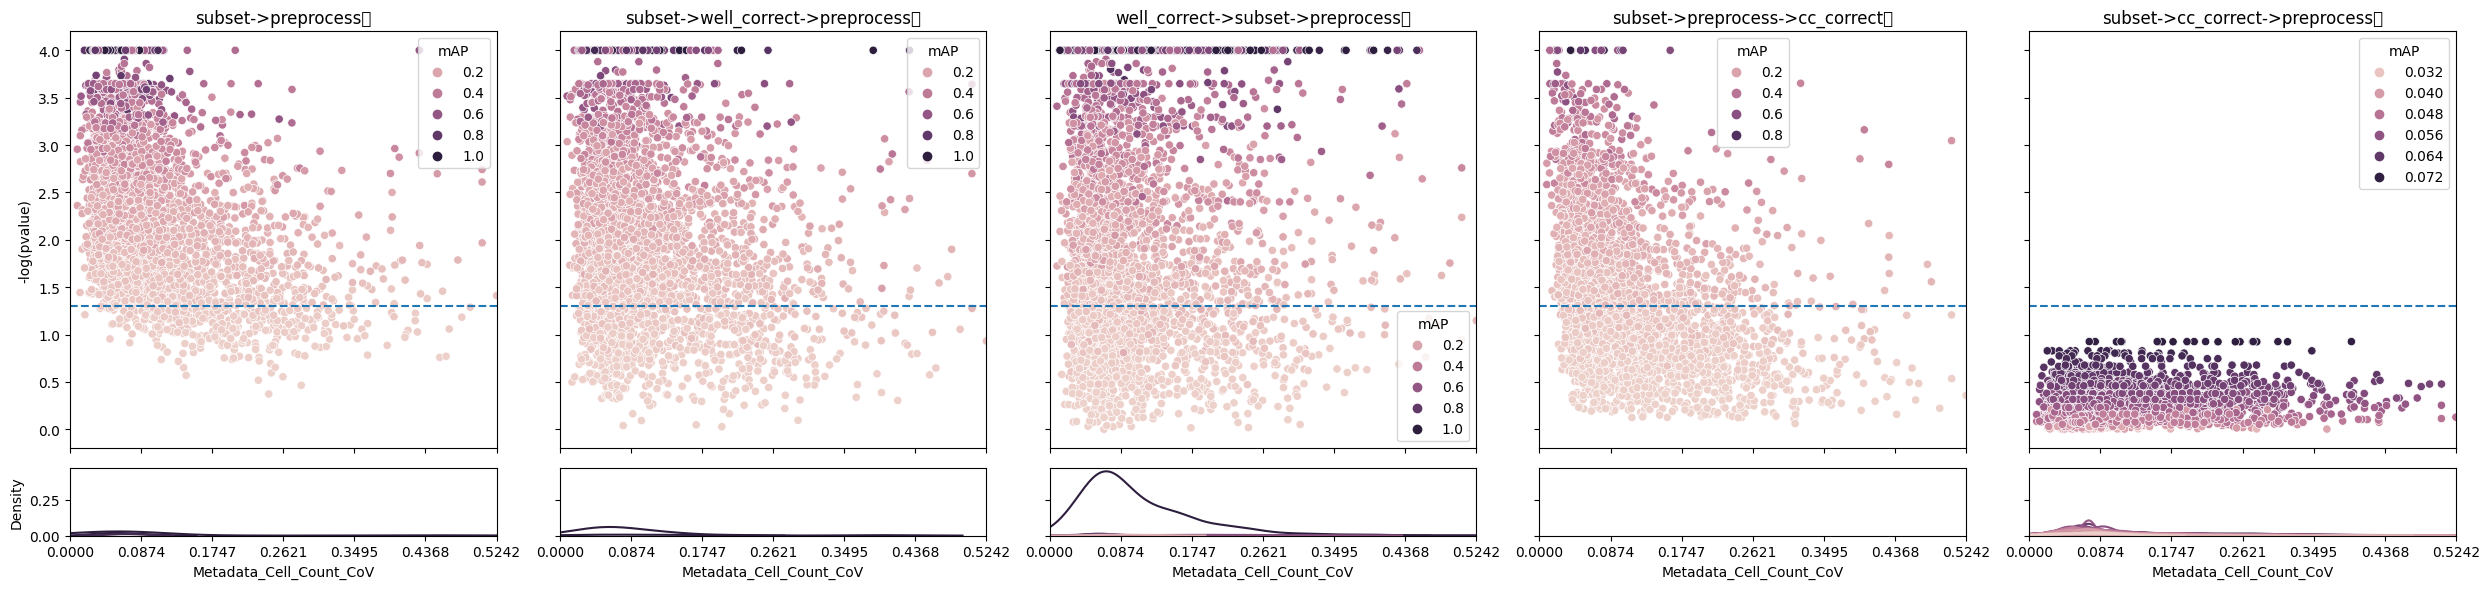

In [16]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, x_col="Metadata_Cell_Count_CoV", hue_col="mAP", ax_line=1.3,
                        figsave_path=figsave_path / "pvalue_vs_ccv")